## 读取VAW-Clean

In [1]:
import json
import os.path as osp
import numpy as np

data_path = '/data/liangkongming/code/KGVA/data/wxr/VAW_Clean_0_1/data'

with open(osp.join(data_path, 'object_index.json')) as f:
    object_index = json.load(f)
    
with open(osp.join(data_path, 'attribute_index.json')) as f:
    attribute_index = json.load(f)

object_index_reversed = {v:k for k, v in object_index.items()}
attribute_index_reversed = {v:k for k, v in attribute_index.items()}

anno = {}
for stage in ['train', 'val', 'test']:
    with open(osp.join(data_path, '{}.json'.format(stage))) as f:
        anno[stage] = json.load(f)

In [2]:
num_obj = len(object_index)
num_att = len(attribute_index)
print(num_obj, num_att)

1763 591


## 生成OA关系

In [3]:
def calculate_num(anno_list, num_obj, num_att):
    obj_att_anno_pos = np.zeros((num_obj, num_att))
    obj_att_anno_neg = np.zeros((num_obj, num_att))
    obj_counter = np.zeros((num_obj))

    for anno_image in anno_list:
        object_name = anno_image['object_name']
        positive_attributes = anno_image['positive_attributes']
        negative_attributes = anno_image['negative_attributes']
        object_index_image = object_index[object_name]
        obj_counter[object_index_image] += 1
        for att in positive_attributes:
            attribute_index_image = attribute_index[att]
            obj_att_anno_pos[object_index_image, attribute_index_image] += 1
        for att in negative_attributes:
            attribute_index_image = attribute_index[att]
            obj_att_anno_neg[object_index_image, attribute_index_image] +=1
    return obj_att_anno_pos, obj_att_anno_neg, obj_counter

oa_anno_pos_train, oa_anno_neg_train, obj_counter_train = calculate_num(
    anno['train'], num_obj, num_att
)

In [4]:
oa_anno_pos_val, oa_anno_neg_val, obj_counter_val = calculate_num(
    anno['val'], num_obj, num_att
)
print(((oa_anno_pos_train == 0) * (oa_anno_pos_val != 0)).sum() , (oa_anno_pos_val != 0).sum())
print(((oa_anno_pos_train == 0) * (oa_anno_pos_val != 0)).sum() / (oa_anno_pos_val != 0).sum())

997 6950
0.14345323741007193


In [5]:
oa_anno_pos_test, oa_anno_neg_test, obj_counter_test = calculate_num(
    anno['test'], num_obj, num_att
)
print(((oa_anno_pos_train == 0) * (oa_anno_pos_test != 0)).sum() , (oa_anno_pos_test != 0).sum())
print(((oa_anno_pos_train == 0) * (oa_anno_pos_test != 0)).sum() / (oa_anno_pos_test != 0).sum())

2873 12697
0.22627392297393084


## 使用OA关系识别affordable属性

In [6]:
oa_anno_pos = oa_anno_pos_train + oa_anno_pos_val + oa_anno_pos_test
oa_anno_neg = oa_anno_neg_train + oa_anno_neg_val + oa_anno_neg_test

valid_att_per_obj = {}
for ii in range(num_obj):
    valid_att_list = []
    valid_att = np.where((oa_anno_pos[ii]+oa_anno_neg[ii]) > 0)[0]
    for jj in valid_att:
        valid_att_list.append(attribute_index_reversed[jj])
    valid_att_per_obj[object_index_reversed[ii]] = valid_att_list

def check_affordable_att(anno_image, valid_att_per_obj):
    object_name = anno_image['object_name']
    positive_attributes = anno_image['positive_attributes']
    negative_attributes = anno_image['negative_attributes']
    valid_att = valid_att_per_obj[object_name]
    for att in positive_attributes + negative_attributes:
        assert(att in valid_att)
        
for anno_image in anno['train']+anno['val']+anno['test']:
    check_affordable_att(anno_image, valid_att_per_obj)

In [8]:
input_path = '/data/liangkongming/code/KGVA/data/wxr/VAW_Clean_0_1/data'

with open(osp.join(input_path, 'train.json')) as f:
    anno_train = json.load(f)

print(len(anno_train))

In [76]:
def add_affordable_att(anno_list, valid_att_per_obj):
    anno_output = []
    for anno_image in anno_list:
        object_name = anno_image['object_name']
        positive_attributes = anno_image['positive_attributes']
        negative_attributes = anno_image['negative_attributes']
        anno_image['candidate_attributes'] = []
        valid_att = valid_att_per_obj[object_name]
        for att in valid_att:
            if att not in positive_attributes and att not in negative_attributes:
                anno_image['candidate_attributes'].append(att)
        anno_output.append(anno_image)
    return anno_output

anno_output = add_affordable_att(anno_train, valid_att_per_obj)

In [10]:
output_path = '/data/liangkongming/code/KGVA/data/wxr/VAW_Clean_0_1/data-aug'
with open(osp.join(output_path, 'train.json'), 'w') as f:
    json.dump(anno_output, f)

with open(osp.join(output_path, 'train.json')) as f:
    anno_train = json.load(f)

In [19]:
data_idx = 10000
print(anno_train[data_idx]['object_name'])
for k in ['positive_attributes', 'negative_attributes', 'candidate_attributes']:
    print(k, anno_train[data_idx][k])

## 利用trainval的OA关系识别affordance属性

In [100]:
oa_anno_pos = oa_anno_pos_train + oa_anno_pos_val
oa_anno_neg = oa_anno_neg_train + oa_anno_neg_val

valid_att_per_obj = {}
for ii in range(num_obj):
    valid_att_list = []
    valid_att = np.where((oa_anno_pos[ii]+oa_anno_neg[ii]) > 0)[0]
    for jj in valid_att:
        valid_att_list.append(attribute_index_reversed[jj])
    valid_att_per_obj[object_index_reversed[ii]] = valid_att_list

for anno_image in anno['train']+anno['val']:
    check_affordable_att(anno_image, valid_att_per_obj)

In [101]:
input_path = '../data/VAW/clean_data'

with open(osp.join(input_path, 'train.json')) as f:
    anno_train = json.load(f)
    
anno_output = add_affordable_att(anno_train, valid_att_per_obj)
print(len(anno_train))

141104


In [102]:
output_path = '../data/VAW/data-trainval'
with open(osp.join(output_path, 'train.json'), 'w') as f:
    json.dump(anno_output, f)

with open(osp.join(output_path, 'train.json')) as f:
    anno_train = json.load(f)

In [103]:
data_idx = 10000
print(anno_train[data_idx]['object_name'])
for k in ['positive_attributes', 'negative_attributes', 'candidate_attributes']:
    print(k, anno_train[data_idx][k])

jeans
positive_attributes ['blue']
negative_attributes ['dark blue']
candidate_attributes ['baggy', 'beige', 'black', 'blue plaid', 'blue striped', 'brown', 'camouflage', 'clean', 'dark', 'dark gray', 'denim', 'dirty', 'faded', 'folded', 'golden brown', 'gray', 'green', 'hanging', 'high', 'holed', 'large', 'light blue', 'light gray', 'long', 'many', 'new', 'orange', 'rolled up', 'short', 'skinny', 'sunlit', 'tan', 'thin', 'tight', 'white', 'wrinkled']


In [107]:
# output_path = '/data/liangkongming/code/KGVA/data/wxr/VAW_Clean_0_1/data-kn'
# with open(osp.join(output_path, 'train.json')) as f:
#     anno_train_kn = json.load(f)
    
output_path = '../data/VAW/data-kn'
with open(osp.join(output_path, 'train.json')) as f:
    anno_train_kn = json.load(f)
    
output_path = '../data/VAW/data-trainval'
with open(osp.join(output_path, 'train.json')) as f:
    anno_train_trainval = json.load(f)
    
output_path = '../data/VAW/data-aug'
with open(osp.join(output_path, 'train.json')) as f:
    anno_train_trainvaltest = json.load(f)

In [111]:
# data_idx = 10000
# print(anno_train_kn[data_idx]['object_name'])
# for k in ['positive_attributes', 'negative_attributes']:
#     print(k, anno_train_trainval[data_idx][k])
for data_idx in range(len(anno_train_kn)):
    print(len(anno_train_trainval[data_idx]['candidate_attributes']), len(anno_train_kn[data_idx]['candidate_attributes']))

175 182
175 182
113 116
114 117
113 116
114 117
173 180
175 182
112 115
111 114
174 181
113 116
174 181
111 114
175 182
59 59
174 181
114 117
175 182
174 181
111 114
175 182
111 114
171 178
114 117
174 181
111 114
108 111
174 181
114 117
173 180
175 182
113 116
175 182
172 179
18 21
113 116
175 182
113 116
174 181
111 114
175 182
175 182
175 182
112 115
112 115
175 182
53 54
114 117
113 116
49 50
112 115
174 181
111 114
113 116
174 181
113 116
60 60
114 117
113 116
97 134
113 116
111 114
113 116
174 181
114 117
113 116
174 181
175 182
172 179
171 178
113 116
114 117
173 180
111 114
51 61
97 134
97 134
100 137
100 137
35 46
174 181
174 181
175 182
175 182
175 182
111 114
48 59
174 181
174 181
114 117
114 117
113 116
112 115
106 109
175 182
175 182
175 182
113 116
60 60


## OA组合在train、val、test上的差异
* internal knowledge
* external knowledge

In [20]:
EPS = np.finfo(float).eps

def normalize_array(input_array):
    ''' normalize along x axis '''
    output_array = input_array / (np.sqrt((input_array **2).sum(axis = 1))[:, np.newaxis] + EPS)
    return output_array

In [21]:
oa_trainval_flag = (oa_anno_pos_train + oa_anno_neg_train + oa_anno_pos_val + oa_anno_neg_val) > 0
oa_test_flag = (oa_anno_pos_test + oa_anno_neg_test) > 0

### co-occurence

In [27]:
oa_trainval_norm = normalize_array(oa_trainval_flag)
obj_corr_internal = oa_trainval_norm.astype(float) @ oa_trainval_norm.astype(float).T

### embedding

In [28]:
# 生成vawc的embedding
import torch

embed_path = '../data/embeddings/clip_obj_embs_d512.pth'
# embed_path = '../data/embeddings/bert_obj_embs_d768.pth'
# embed_path = '../data/embeddings/embeddings/glove_obj_embs_d100.pth'
with open('../data/VAW/data/object_index.json') as f:
    object_index_origin = json.load(f)
    
obj_emb_origin = torch.load(embed_path).numpy()
obj_emb = np.zeros((num_obj, obj_emb_origin.shape[1]),  dtype=obj_emb_origin.dtype)
for ii in range(num_obj):
    object_name = object_index_reversed[ii]
    obj_emb[ii] = obj_emb_origin[object_index_origin[object_name]]
obj_emb = normalize_array(obj_emb)
obj_corr_external = obj_emb.astype(float) @ obj_emb.astype(float).T

In [31]:
# save one-hot embedding

# embed_path = '/data/liangkongming/code/KGVA/data/wxr/embeddings/onehot_obj_embs_d2260.pth'
# onehot_embed = torch.load(embed_path)
# onehot_embed_out = onehot_embed[0:num_obj, 0:num_obj]
# torch.save(
#     onehot_embed_out,
#     '/data/liangkongming/code/KGVA/data/wxr/embeddings/onehot_obj_embs_d1763.pth'
# )

### merge knowledge

In [34]:
def get_att_IoU(list1, list2):
    inter_att = (list1 & list2).sum()
    union_att = (list1 | list2).sum()
    return inter_att, union_att

In [146]:
# obj_correlation1_norm = normalize_array(obj_corr_internal)
# obj_correlation2_norm = normalize_array(obj_corr_external)
# obj_correlation = np.maximum(obj_correlation1_norm, obj_correlation2_norm)
oa_flag = np.zeros_like(oa_trainval_flag).astype(np.uint8)
output = []
for ii in range(num_obj):
    inter_att, union_att = get_att_IoU(oa_trainval_flag[ii], oa_test_flag[ii])
    
    TOP_K = 10
    sorted_index = np.argsort(obj_corr_internal[ii])
    top_k_1 = set(sorted_index[-TOP_K:][::-1])
    sorted_index = np.argsort(obj_corr_external[ii])
    top_k_2 = set(sorted_index[-TOP_K:][::-1])
    for o in top_k_1.intersection(top_k_2):
        if o != ii:
            oa_flag[ii] += oa_trainval_flag[o]
    oa_flag[ii] = (oa_flag[ii] >= 1) + oa_trainval_flag[ii]
    
    inter_att_aug, union_att_aug = get_att_IoU(oa_flag[ii], oa_test_flag[ii])
    if inter_att_aug > inter_att:
        output.append([object_index_reversed[ii], inter_att, inter_att_aug])
#     break

a = (oa_trainval_flag * oa_test_flag).sum()
b = (oa_flag * oa_test_flag).sum()
print(len(output), 'GT:', int(b - a), 'Add,', int(oa_flag.sum() - oa_trainval_flag.sum()))

26 GT: 68 Add, 1117


In [172]:
# obj_correlation1_norm = normalize_array(obj_corr_internal)
# obj_correlation2_norm = normalize_array(obj_corr_external)
# obj_correlation = np.maximum(obj_correlation1_norm, obj_correlation2_norm)
oa_flag = np.zeros_like(oa_trainval_flag).astype(np.uint8)
output = []
for ii in range(num_obj):
    inter_att, union_att = get_att_IoU(oa_trainval_flag[ii], oa_test_flag[ii])
    
    TOP_K = 2
    sorted_index = np.argsort(obj_corr_internal[ii])
    top_k_list = sorted_index[-TOP_K:][::-1]
    for o in top_k_list:
        if o != ii:
            oa_flag[ii] += oa_trainval_flag[o]
    
    TOP_K = 2
    sorted_index = np.argsort(obj_corr_external[ii])
    top_k_list = sorted_index[-TOP_K:][::-1]
    for o in top_k_list:
        if o != ii:
            oa_flag[ii] += oa_trainval_flag[o]
#     print(oa_flag.max(), (oa_flag==2).sum())
    oa_flag[ii] = (oa_flag[ii] >= 1) + oa_trainval_flag[ii]
    
    inter_att_aug, union_att_aug = get_att_IoU(oa_flag[ii], oa_test_flag[ii])
#     print(inter_att, inter_att_aug)
    if inter_att_aug > inter_att:
        output.append([object_index_reversed[ii], inter_att, inter_att_aug])
#     break

a = (oa_trainval_flag * oa_test_flag).sum()
b = (oa_flag * oa_test_flag).sum()
print(len(output), 'GT:', int(b - a), 'Add,', int(oa_flag.sum() - oa_trainval_flag.sum()))

421 GT: 1310 Add, 37965


Trainval: 27756, Test: 24083, IoU: 18348
IK: 305  944  7640
EK:  84   85  6986
IE: 402 1169 18416
IE: 216  470  4821
IE:  51   67  1216

In [ ]:
IE:  51   67  1216

In [205]:
def get_oa_flag(TOP_K, thres):
    oa_flag = np.zeros_like(oa_trainval_flag).astype(np.uint8)
    output = []
    for ii in range(num_obj):
        inter_att, union_att = get_att_IoU(oa_trainval_flag[ii], oa_test_flag[ii])

        sorted_index = np.argsort(obj_corr_internal[ii])
        top_k_list = sorted_index[-TOP_K:][::-1]
        for o in top_k_list:
            if o != ii:
                oa_flag[ii] += oa_trainval_flag[o]

        sorted_index = np.argsort(obj_corr_external[ii])
        top_k_list = sorted_index[-TOP_K:][::-1]
        for o in top_k_list:
            if o != ii:
                oa_flag[ii] += oa_trainval_flag[o]
        oa_flag[ii] = (oa_flag[ii] >= thres) + oa_trainval_flag[ii]

        inter_att_aug, union_att_aug = get_att_IoU(oa_flag[ii], oa_test_flag[ii])
        if inter_att_aug > inter_att:
            output.append([object_index_reversed[ii], inter_att, inter_att_aug])

    a = (oa_trainval_flag * oa_test_flag).sum()
    b = (oa_flag * oa_test_flag).sum()
    print(len(output), 'GT:', int(b - a), 'Add,', int(oa_flag.sum() - oa_trainval_flag.sum()))
    return oa_flag

def get_valid_att_per_obj(oa_flag):
    valid_att_per_obj = {}
    for ii in range(num_obj):
        valid_att = np.where((oa_flag[ii]) > 0)[0]
        valid_att_list = [attribute_index_reversed[x] for x in valid_att]
        valid_att_per_obj[object_index_reversed[ii]] = valid_att_list
    return valid_att_per_obj
# TOP_K = 2
# thres = 2

input_path = '/data/liangkongming/code/KGVA/data/wxr/VAW_Clean_0_1/data'
with open(osp.join(input_path, 'train.json')) as f:
    anno_train = json.load(f)
    
# for TOP_K, thres in [(2,1), (3, 2), (3, 3)]:
for TOP_K, thres in [(3, 1)]:
    print(TOP_K, thres)
    oa_flag = get_oa_flag(TOP_K, thres)
    valid_att_per_obj = get_valid_att_per_obj(oa_flag)
    anno_output = add_affordable_att(anno_train, valid_att_per_obj)
    output_path = '/data/liangkongming/code/KGVA/data/wxr/VAW_Clean_0_1/data-kn-{}{}'.format(TOP_K, thres)
    with open(osp.join(output_path, 'train.json'), 'w') as f:
        json.dump(anno_output, f)

3 2
275 GT: 687 Add, 8636


2 1
421 GT: 1310 Add, 37965
3 1
566 GT: 2037 Add, 72153
3 2
275 GT: 687 Add, 8636
3 3
59 GT: 70 Add, 1062

In [188]:
# for TOP_K, thres in [(2,1), (3, 2), (3, 3)]:
for TOP_K, thres in [(3, 1)]:
    output_path = '../data/VAW/data-kn-{}{}'.format(TOP_K, thres)
    with open(osp.join(output_path, 'train.json')) as f:
        anno_train = json.load(f)
    print(TOP_K, thres)
    print(len(anno_train[0]['candidate_attributes']))
    print(len(anno_train[-1]['candidate_attributes']))

3 1
257
184


In [193]:
with open(osp.join('../data/VAW/clean_data', 'train.json')) as f:
        anno_train1 = json.load(f)

In [194]:
with open(osp.join('/data/liangkongming/code/KGVA/data/wxr/VAW_Clean_0_1/data-kn', 'train.json')) as f:
        anno_train2 = json.load(f)

In [195]:
with open(osp.join('/data/liangkongming/code/KGVA/data/wxr/VAW_Clean_0_1/data-kn-31', 'train.json')) as f:
        anno_train3 = json.load(f)

In [198]:
anno_train1[0]['image_id'], anno_train2[0]['image_id'], anno_train3[0]['image_id'] 

('2315871', '2315871', '2315871')

In [202]:
anno_train2[0].keys()

dict_keys(['image_id', 'instance_id', 'instance_bbox', 'instance_polygon', 'object_name', 'positive_attributes', 'negative_attributes', 'candidate_attributes'])

In [204]:
tag = 'candidate_attributes'
# anno_train1[0][tag], 
len(anno_train2[0][tag]), len(anno_train3[0][tag])

(176, 257)

### save data

In [128]:
input_path = '/data/liangkongming/code/KGVA/data/wxr/VAW_Clean_0_1/data'

with open(osp.join(input_path, 'train.json')) as f:
    anno_train = json.load(f)

In [129]:
print(len(anno_train))
anno_output = add_affordable_att(anno_train, valid_att_per_obj)
print(len(anno_output))

141104
141104


In [130]:
output_path = '/data/liangkongming/code/KGVA/data/wxr/VAW_Clean_0_1/data-kn'
with open(osp.join(output_path, 'train.json'), 'w') as f:
    json.dump(anno_output, f)

In [131]:
with open(osp.join(output_path, 'train.json')) as f:
    anno_train = json.load(f)

In [132]:
data_idx = 30000
print(anno_train[data_idx]['object_name'])
for k in ['positive_attributes', 'negative_attributes', 'candidate_attributes']:
    print(k, anno_train[data_idx][k])

bowl
positive_attributes ['white', 'light blue', 'blue']
negative_attributes ['stacked', 'clear']
candidate_attributes ['almost empty', 'aluminum', 'amber', 'ancient', 'antique', 'black', 'bright', 'bright yellow', 'broken', 'brown', 'ceramic', 'circular', 'clay', 'clean', 'colorful', 'colorless', 'concrete', 'cream colored', 'curved', 'dark', 'dark blue', 'decorative', 'deep', 'dirty', 'disposable', 'empty', 'fancy', 'filled', 'flat', 'folded', 'full', 'glass', 'gray', 'green', 'half filled', 'hanging', 'hard', 'large', 'little', 'long', 'maroon', 'metal', 'mixed', 'old', 'opaque', 'open', 'orange', 'ornate', 'oval shaped', 'painted', 'paper', 'patterned', 'pink', 'plastic', 'porcelain', 'purple', 'rectangular', 'red', 'reflective', 'ridged', 'round', 'rounded', 'rusty', 'shallow', 'shining', 'shiny', 'shiny blue', 'short', 'silver', 'sitting', 'small', 'smooth', 'soft', 'square', 'stained', 'stainless', 'stainless steel', 'stone', 'striped', 'styrofoam', 'tall', 'tan', 'thick', 'tiny

### Finnish

## Save Prior

In [147]:
train_pred = np.load('/data/liangkongming/code/KGVA/data/wxr/VAW_Clean_0_1/data-kn/train_pred.npy')
print(train_pred.shape)
prior = train_pred.mean(axis=0)

(141104, 591)


In [159]:
import pandas as pd

In [161]:
df_train = pd.DataFrame({"Classes": list(attribute_index.keys()), "avg_pred": prior})
df_train.to_csv(path_or_buf="/data/liangkongming/code/KGVA/data/wxr/VAW_Clean_0_1/data-kn/RN50-IGNORE-PRIOR-TRAIN-VAWC.csv",
                        sep=',', header=True, index=False, encoding='utf-8')

## 画图

In [211]:
oa_flag_gt = oa_anno_pos_train + oa_anno_pos_val + oa_anno_pos_test + oa_anno_neg_train + oa_anno_neg_val + oa_anno_neg_test

for TOP_K, thres in [(3, 2)]:
    oa_flag = get_oa_flag(TOP_K, thres)

275 GT: 687 Add, 8636


In [223]:
oa_trainval_flag = (oa_anno_pos_train + oa_anno_neg_train + oa_anno_pos_val + oa_anno_neg_val) > 0
oa_test_flag = oa_trainval_flag + (oa_anno_pos_test + oa_anno_neg_test) > 0

output = []
for ii in range(num_obj):
# for ii in range(1, num_obj):
    a = (oa_trainval_flag[ii] * oa_test_flag[ii]).sum()
    b = (oa_flag[ii] * oa_test_flag[ii]).sum()
    if b > a:
        output.append([object_index_reversed[ii], a, b, a/b])

In [236]:
sub_output = output[0:10]

In [244]:
output

[['animal', 89, 93, 0.956989247311828],
 ['apple', 46, 48, 0.9583333333333334],
 ['area', 65, 68, 0.9558823529411765],
 ['arm', 60, 61, 0.9836065573770492],
 ['bag', 93, 94, 0.9893617021276596],
 ['banana', 58, 62, 0.9354838709677419],
 ['beads', 12, 14, 0.8571428571428571],
 ['beak', 15, 16, 0.9375],
 ['bear', 131, 132, 0.9924242424242424],
 ['bed', 64, 69, 0.927536231884058],
 ['bedside lamp', 0, 1, 0.0],
 ['bench', 117, 120, 0.975],
 ['bird', 84, 89, 0.9438202247191011],
 ['blade', 21, 22, 0.9545454545454546],
 ['blanket', 66, 67, 0.9850746268656716],
 ['block', 27, 28, 0.9642857142857143],
 ['board', 77, 78, 0.9871794871794872],
 ['boat', 85, 88, 0.9659090909090909],
 ['border', 22, 24, 0.9166666666666666],
 ['bottle', 65, 67, 0.9701492537313433],
 ['bowl', 100, 103, 0.970873786407767],
 ['box', 74, 77, 0.961038961038961],
 ['boy', 156, 167, 0.9341317365269461],
 ['branch', 45, 46, 0.9782608695652174],
 ['bread', 63, 65, 0.9692307692307692],
 ['bricks', 41, 42, 0.9761904761904762],

findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times Ne

a


findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times Ne

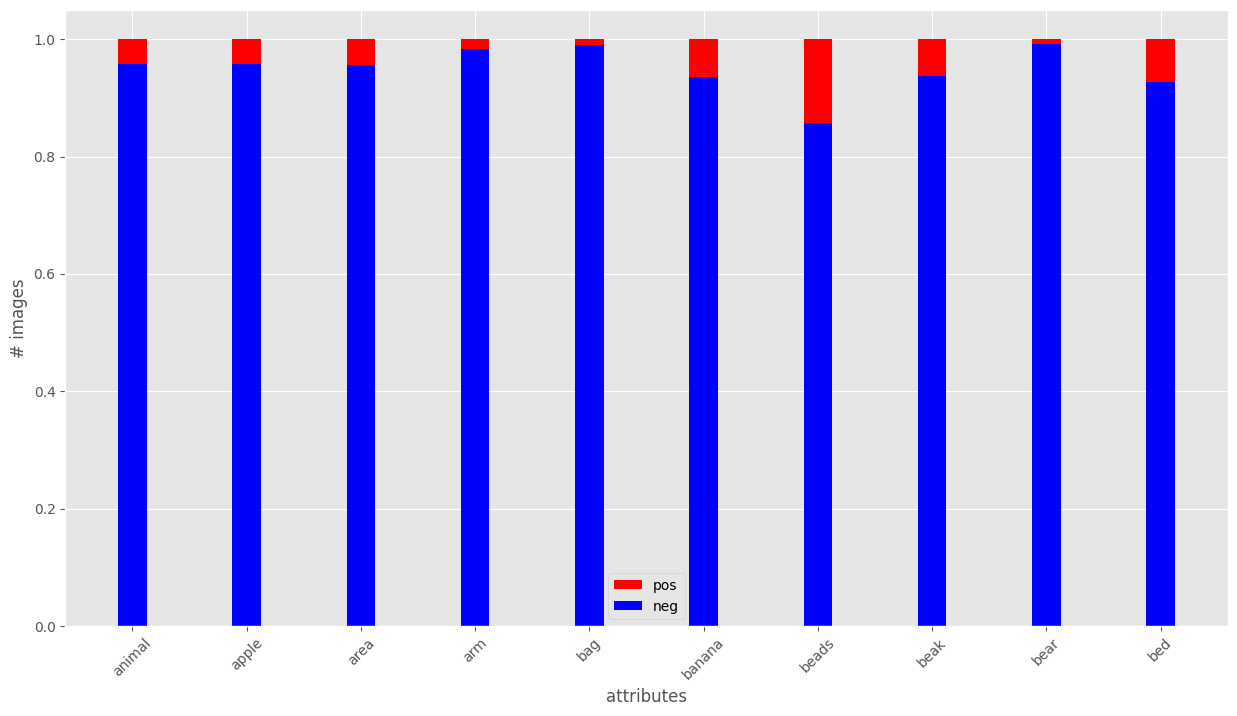

In [243]:
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline

plt.style.use("ggplot")
plt.rc('font', family='Times New Roman')

shops = [x[0] for x in sub_output]
sales_product_1 = [1 for x in sub_output]
sales_product_2 = [x[3] for x in sub_output]

# 创建分组柱状图，需要自己控制x轴坐标
xticks = np.arange(len(shops))

fig, ax = plt.subplots(figsize=(15, 8))
# 所有门店第一种产品的销量，注意控制柱子的宽度，这里选择0.25
ax.bar(xticks, sales_product_1, width=0.25, label="pos", color="red")
# 所有门店第二种产品的销量，通过微调x轴坐标来调整新增柱子的位置
ax.bar(xticks, sales_product_2, width=0.25, label="neg", color="blue")

# ax.set_title('a', fontsize=15)
ax.set_xlabel("attributes")
ax.set_ylabel("# images")
ax.legend()

# 最后调整x轴标签的位置
ax.set_xticks(xticks)
ax.set_xticklabels(shops, rotation=45)
print('a')